In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Create some artificial data

In [6]:
n_datapoints = 30
noise_level = 0.3
test_input = 3

X = np.linspace(0, 2 * np.pi, n_datapoints)
true = np.sin(X)
y = true + np.random.normal(0, noise_level, n_datapoints)


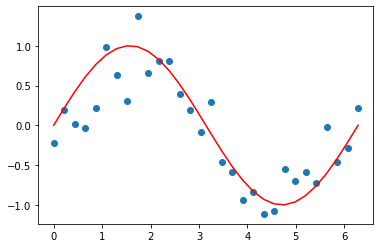

In [7]:
plt.scatter(X, y)
plt.plot(X, true, c='r')

# Define Covariance function

In [61]:
def rbf(x, x_prime, signal_var=1, len_scale=1, noise_var=0.1):
    return signal_var * np.exp(-(1/(2 * len_scale) * np.power(np.linalg.norm(x - x_prime), 2))) + noise_var

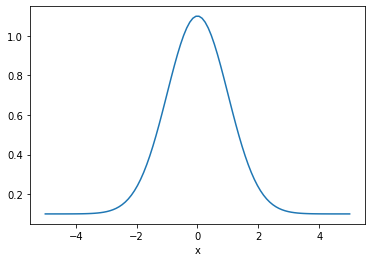

In [62]:
plt.plot(np.linspace(-5, 5, 100), [rbf(0, x) for x in np.linspace(-5, 5, 100)])
plt.xlabel('x')
plt.show()

In [75]:
def calculate_cov_matrix(X, k, signal_var=1, len_scale=1, noise_var=0.1):
    all_values = []
    
    for x_x in X:
        for x_y in X:
            all_values.append(k(x_x, x_y, signal_var, len_scale, noise_var))

    return np.array(all_values).reshape(len(X), len(X))

In [11]:
K = calculate_cov_matrix(X, k=rbf) 

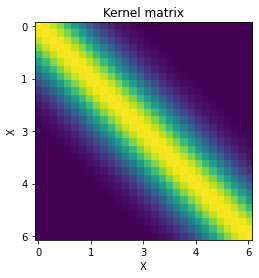

In [12]:
plt.imshow(K)
plt.title('Kernel matrix')
plt.xlabel("X")
plt.ylabel("X")
plt.xticks(np.linspace(0, n_datapoints - 1, 5), np.linspace(X.min(), X.max(), 5).astype(int))
plt.yticks(np.linspace(0, n_datapoints - 1, 5), np.linspace(X.min(), X.max(), 5).astype(int))
plt.show()

# Gaussian Process regression

In [13]:
# Calculates the covariance between a test point and N training points (so gives a vector of N covariances)
def calculate_test_point_cov(test_input, X, k):
    k_star = []

    for train_point in X:
        k_star.append(k(test_input, train_point))

    return np.array(k_star)

In [14]:
def gaussian_process_regression(X, y, k, noise_level, test_input):
    k_star = calculate_test_point_cov(test_input, X, k)
    K = calculate_cov_matrix(X, k)
    
    L = np.linalg.cholesky(K + noise_level * np.identity(len(X))) # Calculate the upper Cholensky decomp
    transform_cholensky_y = np.linalg.solve(L, y) # Calculate the matrix transforming L decomp into y (Lx = y)
    a = np.linalg.solve(L.T, transform_cholensky_y) # Calculate the transform from L.T into the transformation of L into y
    
    # Calculate the function value and variance
    f_star = k_star.T @ a # For each transformation give the weight (distance from training example)
    v = np.linalg.solve(L, k_star)
    variance = k(test_input, test_input) - (v.T @ v)
    
    # Calculate the log posterior probability of y given X
    log_p = -(1/2 * (y.T @ a)) - np.log(np.diag(L)).sum() - ((len(X) / 2) * np.log(2 * np.pi)) # Log of gaussian
    
    return f_star, variance, log_p

# Predict the values over the same given interval

In [15]:
predicted_vals = []
predicted_vars = []
for val in np.linspace(0, 2 * np.pi, n_datapoints):
    mean, _, _ = gaussian_process_regression(X, y, rbf, noise_level, val)
    predicted_vals.append(mean)

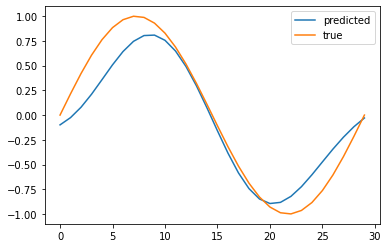

In [16]:
plt.plot(predicted_vals, label='predicted')
plt.plot(np.sin(X), label='true')
plt.legend()
plt.show()

# Exercises

In [2]:
import numpy as np

In [174]:
X = np.linspace(-5, 5, 100) 

cov_matrix = calculate_cov_matrix(X, rbf, signal_var=1, len_scale=0.8, noise_var=0) # 100 by 100 matrix
data = []
for i in range(10000): # Sample functions from the distribution, 
    data.append(np.random.multivariate_normal(np.zeros(cov_matrix.shape[0]), cov_matrix))


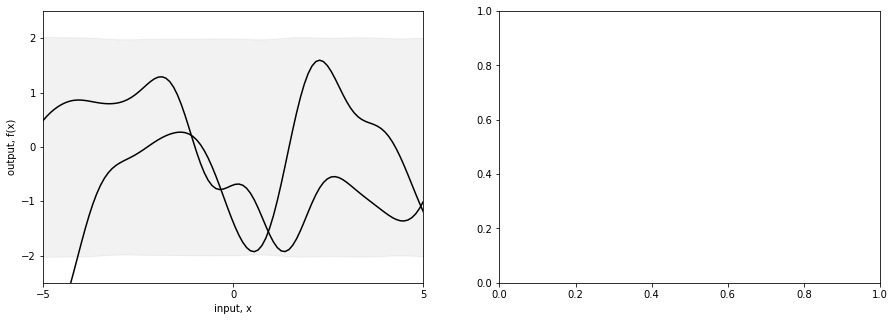

In [176]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

ax[0].plot(X, data[0], c='k')
ax[0].plot(X, data[6], c='k')
ax[0].set_xticks(np.linspace(-5, 5, 3).astype(int))
ax[0].set_ylim(-2.5, 2.5)
ax[0].set_xlim(-5, 5)
ax[0].set_xlabel('input, x')
ax[0].set_ylabel('output, f(x)')
std = np.array(data).std(axis=0) * 2
ax[0].fill_between(X, std, -std, color='grey', alpha=0.10)

plt.show()

De linker afbeeling laat zien wat er gebeurt als je over een range van (-5, 5) evenredig 100 datapunten sampled uit een normaal verdeling en waar de covariance matrix de covariance is tussen alle datapunten berekent met een radial basis function